In [47]:
# %pip install pandas
# %pip install torch
# %pip install scikit-learn
# %pip install torchvision
# %pip install numpy
# %pip install matplotlib
# %pip install reformer_pytorch

In [48]:
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import copy
import yfinance as yf
from datetime import datetime, timedelta
import torch
import numpy as np
import time

In [49]:

from exp.exp_main import Exp_Main as Exp
from data_provider.data_factory import data_provider

In [50]:
from conf import get_train_config

In [51]:
# import subprocess
# import os

# # Create the kernel_jupyter folder if it doesn't exist
# os.makedirs('kernel_jupyter', exist_ok=True)

# # Get the current kernel name
# kernel_name = !jupyter kernelspec list | grep python
# print(f"Current kernel: {kernel_name}")

# # Export the current environment to a requirements file
# subprocess.run(['pip', 'freeze'], stdout=open('kernel_jupyter/requirements.txt', 'w'))

# print("Environment saved to kernel_jupyter/requirements.txt")

In [52]:
args, setting = get_train_config()

Data Preprep

In [53]:
_, train_loader = data_provider(args, flag='train')
_, test_loader = data_provider(args, flag='test')

(3018, 101)
        AAPL       ABBV        ABT        ACN       ADBE        AIG   AMD  \
0  17.156702  32.166576  30.329454  66.105843  59.290001  38.581757  3.95   
1  16.779840  32.364609  30.654730  66.325874  59.160000  38.741524  4.00   
2  16.871340  31.182650  31.059338  65.625122  58.119999  38.437195  4.13   
3  16.750687  31.244539  30.821325  66.423615  58.970001  38.962158  4.18   
4  16.856760  31.164068  31.098995  66.936974  58.900002  39.418671  4.18   
5  16.641500  31.696274  31.154533  67.588821  59.090000  39.646919  4.09   
6  16.530458  31.498238  31.392538  67.792519  59.529999  39.730614  4.17   
7  16.616991  31.080353  31.201077  66.048813  58.599998  39.152378  4.13   
8  16.947643  31.560623  31.568058  66.773987  60.369999  39.380627  4.30   
9  17.287910  31.254995  31.536127  68.623627  61.680000  39.646919  4.47   

        AMGN        AMT       AMZN  ...        TXN        UNH        UNP  \
0  82.727364  60.054550  19.898500  ...  31.033844  61.498772  6

Create Models

In [54]:
for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(train_loader):
         print(i)
         print(batch_x.shape, batch_y.shape, batch_x_mark.shape, batch_y_mark.shape)
         break

0
torch.Size([32, 96, 98]) torch.Size([32, 72, 98]) torch.Size([32, 96, 3]) torch.Size([32, 72, 3])


In [55]:
'''Dense Model'''

pred_len = 24

class DenseModel(torch.nn.Module): 
    def __init__(self, input_size = 96*98, output_size=pred_len*98):
        super(DenseModel, self).__init__()

        self.model = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(input_size, 512),
            torch.nn.LeakyReLU(),
            torch.nn.Dropout(0.1),
            torch.nn.Linear(512, 256),
            torch.nn.LeakyReLU(),
            torch.nn.Dropout(0.1),
            torch.nn.Linear(256, 128),
            torch.nn.LeakyReLU(),
            torch.nn.Dropout(0.1),
            torch.nn.Linear(128, output_size)
            
        )

        self.loss = torch.nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)


    def forward(self, x):
        y = self.model(x)
        return y.reshape((x.shape[0], pred_len, 98))
    



Train Models

In [56]:
'''Dense Model'''

n_epochs = args.train_epochs # incase i want to train them for different n_of_epochs

def train_dense(train_loader):
    model = DenseModel()

    loss_fn = model.loss
    optimizer = model.optimizer

    train_steps = len(train_loader)


    for epoch in range(n_epochs):

        running_loss = 0.0
        last_loss = 0.0

        train_loss = []

        model.train(True)

        epoch_time = time.time()
        for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(train_loader):

            optimizer.zero_grad()

            batch_x = batch_x.float()
            batch_y = batch_y.float()
            output = model(batch_x)

            batch_y = batch_y[:, -pred_len:, :]

            loss = loss_fn(output, batch_y)

            train_loss.append(loss.item())

            loss.backward()
            optimizer.step()

        train_loss = np.average(train_loss)

        vali_loss = 0.0
        test_loss = 0.0

        print("Epoch: {} time: {}".format(epoch + 1, time.time() - epoch_time))
        print("Epoch: {0}, Steps: {1} | Train Loss: {2:.7f} Vali Loss: {3:.7f} Test Loss: {4:.7f}".format(
                epoch + 1, train_steps, train_loss, vali_loss, test_loss))



    return model


dense_model = train_dense(train_loader)

print('Dense Training Finished!')


Epoch: 1 time: 2.147749900817871
Epoch: 1, Steps: 62 | Train Loss: 0.5018140 Vali Loss: 0.0000000 Test Loss: 0.0000000
Epoch: 2 time: 2.234360933303833
Epoch: 2, Steps: 62 | Train Loss: 0.1695150 Vali Loss: 0.0000000 Test Loss: 0.0000000
Epoch: 3 time: 2.4475297927856445
Epoch: 3, Steps: 62 | Train Loss: 0.1115125 Vali Loss: 0.0000000 Test Loss: 0.0000000
Epoch: 4 time: 2.22477650642395
Epoch: 4, Steps: 62 | Train Loss: 0.0932229 Vali Loss: 0.0000000 Test Loss: 0.0000000
Epoch: 5 time: 2.135483741760254
Epoch: 5, Steps: 62 | Train Loss: 0.0857271 Vali Loss: 0.0000000 Test Loss: 0.0000000
Epoch: 6 time: 2.169435739517212
Epoch: 6, Steps: 62 | Train Loss: 0.0759158 Vali Loss: 0.0000000 Test Loss: 0.0000000
Epoch: 7 time: 2.0015759468078613
Epoch: 7, Steps: 62 | Train Loss: 0.0694208 Vali Loss: 0.0000000 Test Loss: 0.0000000
Epoch: 8 time: 2.014458179473877
Epoch: 8, Steps: 62 | Train Loss: 0.0673681 Vali Loss: 0.0000000 Test Loss: 0.0000000
Epoch: 9 time: 1.959191083908081
Epoch: 9, Step

In [59]:
for arg in args.items():
    print(arg)

('is_training', 1)
('model_id', 'test')
('model', 'Autoformer')
('data', 'sp100')
('root_path', 'data')
('data_path', 'sp100_combined_close.csv')
('features', 'M')
('target', 'M')
('frequency', 'D')
('freq', 'd')
('checkpoints', './autoformer_checkpoints/')
('sequence_len', 96)
('label_len', 48)
('pred_len', 24)
('enc_in', 98)
('dec_in', 98)
('c_out', 98)
('d_model', 512)
('n_heads', 8)
('e_layers', 2)
('d_layers', 1)
('d_ff', 2048)
('moving_avg', 50)
('faction', 1)
('distil', True)
('dropout', 0.05)
('activation', 'gelu')
('output_attention', True)
('do_predict', None)
('num_workers', 1)
('itr', None)
('train_epochs', 10)
('batch_size', 32)
('patience', 3)
('learning_rate', 0.0001)
('des', 'train')
('loss', 'mse')
('lradj', 'type1')
('use_amp', False)
('use_gpu', False)
('gpu', None)
('use_multi_gpu', False)
('devices', None)
('embed', 'timeF')
('factor', 3)


In [ ]:
exp = Exp(args)

In [ ]:
    

print(f'Started training for {args.train_epochs}')
exp.train(setting)
print(f'Training call done, who knows if it worked?')

Use CPU
Started training for 10
(3018, 101)
        AAPL       ABBV        ABT        ACN       ADBE        AIG   AMD  \
0  17.156702  32.166576  30.329454  66.105843  59.290001  38.581757  3.95   
1  16.779840  32.364609  30.654730  66.325874  59.160000  38.741524  4.00   
2  16.871340  31.182650  31.059338  65.625122  58.119999  38.437195  4.13   
3  16.750687  31.244539  30.821325  66.423615  58.970001  38.962158  4.18   
4  16.856760  31.164068  31.098995  66.936974  58.900002  39.418671  4.18   
5  16.641500  31.696274  31.154533  67.588821  59.090000  39.646919  4.09   
6  16.530458  31.498238  31.392538  67.792519  59.529999  39.730614  4.17   
7  16.616991  31.080353  31.201077  66.048813  58.599998  39.152378  4.13   
8  16.947643  31.560623  31.568058  66.773987  60.369999  39.380627  4.30   
9  17.287910  31.254995  31.536127  68.623627  61.680000  39.646919  4.47   

        AMGN        AMT       AMZN  ...        TXN        UNH        UNP  \
0  82.727364  60.054550  19.8985

KeyboardInterrupt: 

Testing

In [ ]:
from utils.metrics import metric

def test(test_loader, model, call_func):
    
    preds = []
    trues = []

    model.eval()

    with torch.no_grad():
        for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(test_loader):

            batch_x = batch_x.float()
            batch_y = batch_y.float()
            
            batch_x_mark = batch_x_mark.float()
            batch_y_mark = batch_y_mark.float()

            outputs, batch_y = call_func(batch_x, batch_y, batch_x_mark, batch_y_mark)

            preds.append(outputs.detach().cpu().numpy())
            trues.append(batch_y.detach().cpu().numpy())

        preds = np.concatenate(preds, axis=0)
        trues = np.concatenate(trues, axis=0)
        print('test shape:', preds.shape, trues.shape)
        preds = preds.reshape(-1, preds.shape[-2], preds.shape[-1])
        trues = trues.reshape(-1, trues.shape[-2], trues.shape[-1])
        print('test shape:', preds.shape, trues.shape)


        mae, mse, rmse, mape, mspe = metric(preds, trues)
        print('mse:{}, mae:{}'.format(mse, mae))

        return preds, trues

In [ ]:
def func(batch_x, batch_y, batch_x_mark, batch_y_mark):
    return dense_model(batch_x), batch_y[:, -pred_len:, :]


auto_tpred, auto_trains = test(train_loader, exp.model, exp._predict)
dense_tpred, dense_trains = test(train_loader, dense_model, func)

auto_preds, auto_trues = test(test_loader, exp.model, exp._predict)
dense_preds, dense_trues = test(test_loader, dense_model, func)

test shape: (1984, 24, 98) (1984, 24, 98)
test shape: (1984, 24, 98) (1984, 24, 98)
mse:0.06914517283439636, mae:0.18598078191280365
test shape: (1984, 24, 98) (1984, 24, 98)
test shape: (1984, 24, 98) (1984, 24, 98)
mse:0.037505995482206345, mae:0.13205666840076447
test shape: (578, 24, 98) (578, 24, 98)
test shape: (578, 24, 98) (578, 24, 98)
mse:0.7007208466529846, mae:0.5591049790382385
test shape: (578, 24, 98) (578, 24, 98)
test shape: (578, 24, 98) (578, 24, 98)
mse:8.61819076538086, mae:1.9035907983779907


Data Analysis

In [ ]:
print(auto_trues)

[[[ 2.2549405   0.16259085  2.0715857  ...  1.6340668   4.159635
    0.85446894]
  [ 2.3024702   0.17908421  2.0676782  ...  1.6105734   4.164123
    0.89697474]
  [ 2.2552974   0.16459034  2.1208813  ...  1.6316694   4.325061
    0.90095985]
  ...
  [ 1.9390895   0.07662679  2.2889104  ...  1.547644    5.0393405
    0.6180284 ]
  [ 1.9052384   0.05563587  2.2414174  ...  1.5255884   3.942915
    0.6459236 ]
  [ 1.9430367   0.07262819  2.2825978  ...  1.5749732   4.0858984
    0.63662523]]

 [[ 2.3024702   0.17908421  2.0676782  ...  1.6105734   4.164123
    0.89697474]
  [ 2.2552974   0.16459034  2.1208813  ...  1.6316694   4.325061
    0.90095985]
  [ 2.1780636   0.14859717  2.0742908  ...  1.6082958   4.435344
    0.8106337 ]
  ...
  [ 1.9052384   0.05563587  2.2414174  ...  1.5255884   3.942915
    0.6459236 ]
  [ 1.9430367   0.07262819  2.2825978  ...  1.5749732   4.0858984
    0.63662523]
  [ 2.0016484   0.10461497  2.3243797  ...  1.5873194   4.2025948
    0.6459236 ]]

 [[ 2.25

In [ ]:
print(auto_trues.shape)
print(dense_trues.shape)
print(auto_preds.shape)
print(dense_preds.shape)

(578, 24, 98)
(578, 24, 98)
(578, 24, 98)
(578, 24, 98)


In [ ]:
print(auto_trues[:, 0,0 ])

[2.2549405 2.3024702 2.2552974 2.1780636 2.196481  2.2148986 2.2550604
 2.272051  2.2892807 2.3086488 2.2846465 2.2672985 2.2819145 2.2353356
 2.2829833 2.2703042 2.2682703 2.2325058 1.9783229 2.0022469 1.9681562
 1.9390895 1.9052384 1.9430367 2.0016484 1.9796392 2.0491354 1.9947112
 2.0143285 1.9017708 1.8552394 1.8462684 1.7966279 1.7962694 1.8230629
 1.79914   1.7855046 1.7377776 1.7078741 1.6602671 1.7006971 2.1289184
 2.111814  2.1303542 2.100331  2.1831038 2.1753292 2.1839416 2.2430317
 2.280232  2.2203047 2.2441084 2.1811907 2.2624092 2.2418356 2.2109747
 2.2402806 2.3455424 2.3185089 2.3862112 2.3299913 2.3039165 2.291835
 2.2261655 2.1998506 2.228678  2.2305915 2.2209024 2.2319078 2.2372904
 2.2264047 2.2159984 2.267911  2.2948244 2.314083  2.2360933 2.269346
 2.230353  2.3015485 2.3213053 2.3367257 2.283117  2.3213053 2.2935972
 2.30456   2.3435922 2.348049  2.345761  2.2714317 2.2297494 2.2911887
 2.30179   2.2392669 2.30456   2.30697   2.330581  2.3160043 2.3432307
 2.36744

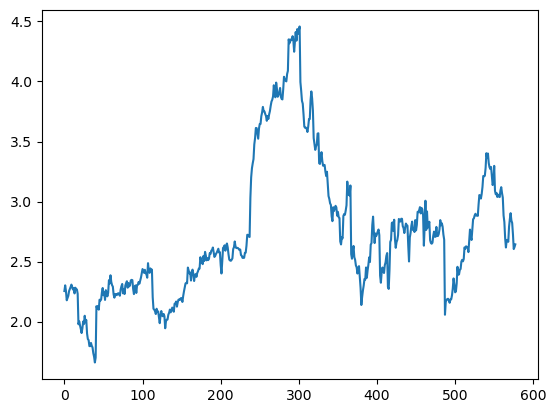

In [ ]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.plot(auto_trues[:, 0, 0])
plt.show()

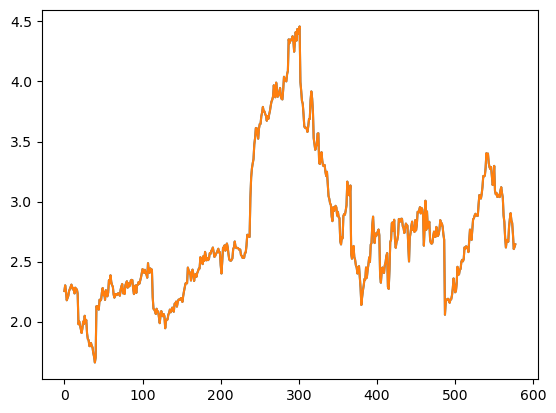

In [ ]:
plt.plot(np.arange(len(auto_trues[:, 0, 0])), auto_trues[:, 0, 0])
plt.plot(np.arange(len(dense_trues[:, 0, 0])), dense_trues[:, 0, 0])

plt.show()

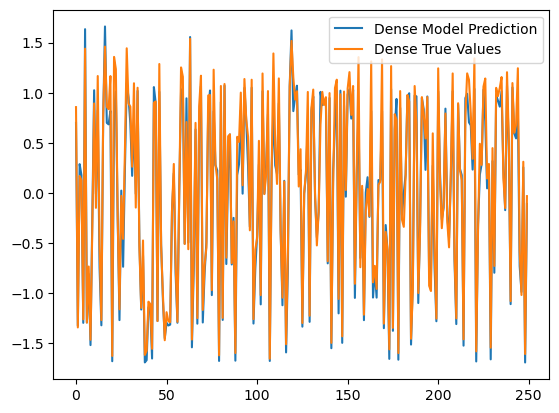

In [ ]:
plt.plot(dense_tpred[1000:1250, 0, 0], label='Dense Model Prediction')
plt.plot(dense_trains[1000:1250, 0, 0], label='Dense True Values')
plt.legend()

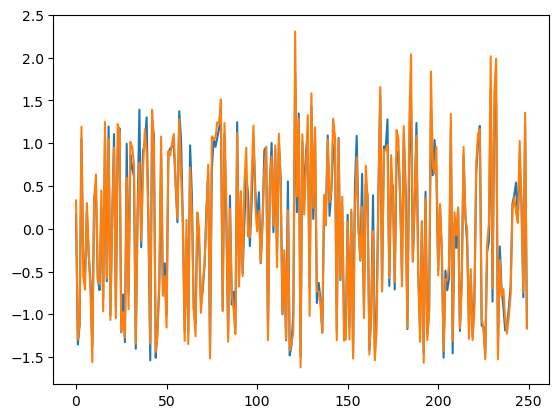

In [ ]:
plt.plot(auto_tpred[1000:1250, 0, 0], label='Autoformer Prediction')
plt.plot(auto_trains[1000:1250, 0, 0], label='True Values')


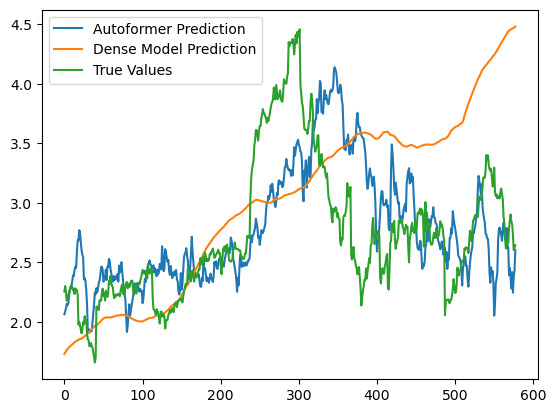

In [ ]:
plt.plot(auto_preds[:, 0, 0], label='Autoformer Prediction')
plt.plot(dense_preds[:, 0, 0], label='Dense Model Prediction')
plt.plot(auto_trues[:, 0, 0], label='True Values')
# plt.plot(dense_trues[:, 0, 0], label='Dense True Values')
plt.legend()

In [ ]:
plt.plot(auto_preds[:, 0, 0], label='Autoformer Prediction')

In [ ]:
inverse_pred = test_loader.inverse_transform()